<a href="https://colab.research.google.com/github/sarthakkaushik/Diploma-Program-in-ML-and-AI/blob/main/DCGAN_On_MNIST_Dataset_%26_Gradient_Tape.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#GradientTape

In [1]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers


# Helper libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import datetime

In [2]:
# For automatic differentiation
# Very useful when we want to have fine control over the differentiation

# Refer: https://www.tensorflow.org/api_docs/python/tf/GradientTape

tf.keras.backend.clear_session()  # For easy reset of notebook state.
x = tf.Variable(3.0, trainable=True)
with tf.GradientTape() as t:
    t.watch(x)
    y = x**2

print(t.gradient(y, x).numpy())

6.0


In [3]:
x = tf.constant(3.0)
with tf.GradientTape() as g:
  g.watch(x)
  with tf.GradientTape() as gg:
    gg.watch(x)
    y = x * x
  dy_dx = gg.gradient(y, x)     # Will compute to 6.0
d2y_dx2 = g.gradient(dy_dx, x)  # Will compute to 2.0

print(dy_dx)
print(d2y_dx2)

tf.Tensor(6.0, shape=(), dtype=float32)
tf.Tensor(2.0, shape=(), dtype=float32)


In [4]:
x = tf.constant(3.0)
with tf.GradientTape() as g:
  g.watch(x)
  y = x * x
  z = y * y
dz_dx = g.gradient(z, x)  # 108.0 (4*x^3 at x = 3)
dy_dx = g.gradient(y, x)  # 6.0



RuntimeError: ignored

#Updated

In [5]:
x = tf.Variable(3.0, trainable=True)
with tf.GradientTape(persistent=True) as g:
  g.watch(x)
  y = x * x
  z = y * y
dz_dx = g.gradient(z, x)  # 108.0 (4*x^3 at x = 3)
dy_dx = g.gradient(y, x)  # 6.0

print(dz_dx,dy_dx)


del g  # Drop the reference to the tape

tf.Tensor(108.0, shape=(), dtype=float32) tf.Tensor(6.0, shape=(), dtype=float32)


In [6]:
# gradient w.r.t multiple variables

x = tf.constant(3.0)
y = tf.constant(4.0)
with tf.GradientTape(persistent=True) as g:
  g.watch(x)
  g.watch(y)
  z = y * y + x * x
dz_dx_dy = g.gradient(z, [x,y])  

print(x)
print(y)
print(dz_dx_dy)


tf.Tensor(3.0, shape=(), dtype=float32)
tf.Tensor(4.0, shape=(), dtype=float32)
[<tf.Tensor: shape=(), dtype=float32, numpy=6.0>, <tf.Tensor: shape=(), dtype=float32, numpy=8.0>]


## Deep Convolutional GAN (DCGAN)

In [7]:
# Source: https://www.tensorflow.org/tutorials/generative/dcgan

tf.keras.backend.clear_session()  # For easy reset of notebook state.

import glob
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from tensorflow.keras import layers
import time

from IPython import display

In [8]:
# load all of MNIST dataset
(train_images, train_labels), (_, _) = tf.keras.datasets.mnist.load_data()
print(train_images.shape)

11501568/11490434 [==============================] - 0s 0us/step
(60000, 28, 28)


In [9]:
# Standarize image data
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
print(train_images.shape)

# [-1, 1] normalization
train_images = (train_images - 127.5) / 127.5 # Normalize the images to [-1, 1] # 127.5 because it lies between 0 to 255 size of the image

(60000, 28, 28, 1)


In [10]:
# Convert train_images into a tf.data.Dataset 
# Always do this step because it make easy for tensorflow to process the data and additionally give us more functionality 
BUFFER_SIZE = 60000
BATCH_SIZE = 256

# Batch and shuffle the data
# Refer: https://www.tensorflow.org/api_docs/python/tf/data/Dataset#from_tensor_slices
'''
Creates a Dataset whose elements are slices of the given tensors. 
The given tensors are sliced along their first dimension.
'''

train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

print(train_dataset)

<BatchDataset shapes: (None, 28, 28, 1), types: tf.float32>


In [11]:
#our obj is here is that Genrator take bunch noise of 1x100 dim and outputs 28x28x1 image from that noise
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(7*7*256, use_bias=False, input_shape=(100,))) #7*7*256 this has been taken from tesnflow doc after they have hypertuned the parameter
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU()) # to avoid dead neouron 

    model.add(layers.Reshape((7, 7, 256)))
    
    # assert is used to debug
    assert model.output_shape == (None, 7, 7, 256) # Note: None is the batch size

    
    # Refer: https://medium.com/@vaibhavshukla182/why-do-we-need-conv2d-transpose-2534cd2a4d98
    # Conv2DTranspose <=> DeConvolution
    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 7, 7, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 14, 14, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 28, 28, 1)

    return model

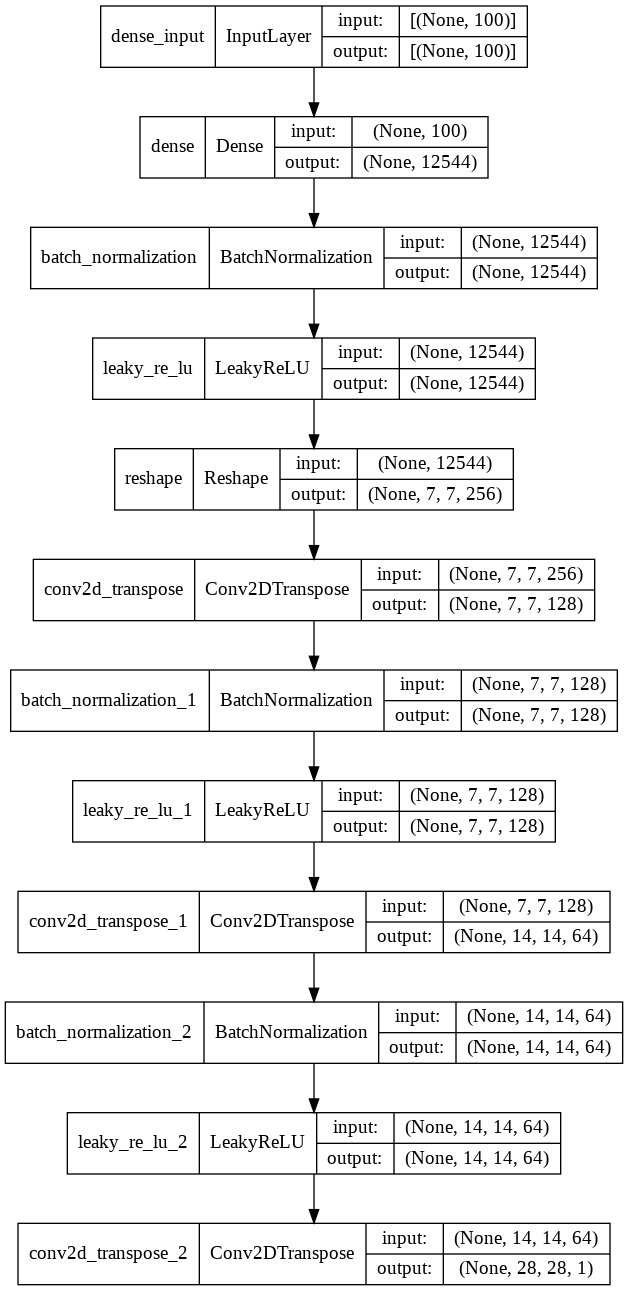

In [12]:
generator = make_generator_model()

keras.utils.plot_model(generator, 'generator.png', show_shapes=True)

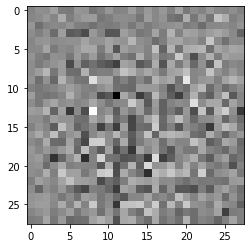

In [13]:
noise = tf.random.normal([1, 100]) # creating 1 randome sample of 100 dimension

# forward-pass through the generator 
generated_image = generator(noise, training=False)

plt.imshow(generated_image[0, :, :, 0], cmap='gray')

In [14]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same',
                                     input_shape=[28, 28, 1]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

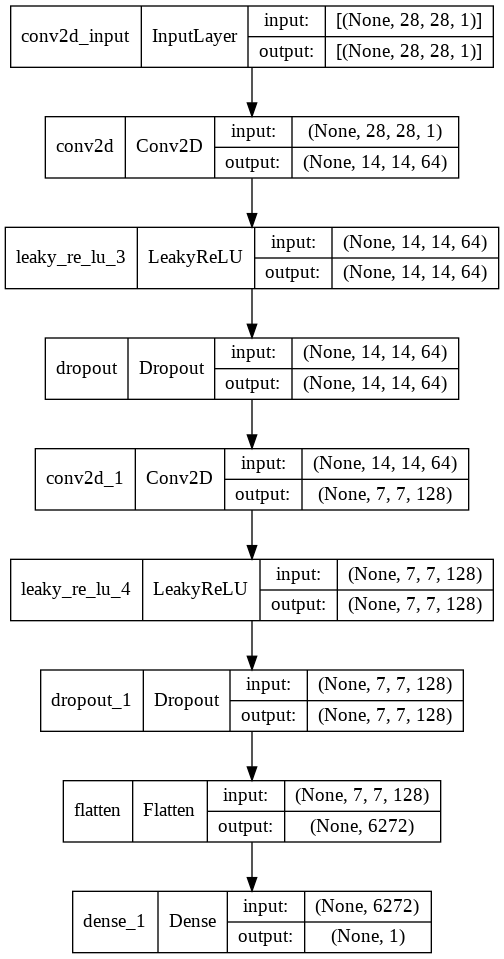

In [15]:
discriminator = make_discriminator_model()
keras.utils.plot_model(discriminator, 'discriminator.png', show_shapes=True)

In [16]:
decision = discriminator(generated_image) # forward-pass. model not yet trained
print (decision)

tf.Tensor([[-0.00350742]], shape=(1, 1), dtype=float32)


In [17]:
# Loss: Binary CrossEntropy <=> log-loss

# This method returns a helper function to compute cross entropy loss
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [18]:
# For the discrimanator,  0 => fake and 1 => real image
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output) # tf.ones creates a tensor of ones
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output) #tf.zeros creates a tensor of zeros
    total_loss = real_loss + fake_loss
    return total_loss

In [19]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [20]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [21]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator) # what objects to store in a ckpt

In [22]:
EPOCHS = 50
noise_dim = 100
num_examples_to_generate = 16

# We will reuse these test_random_vectors overtime (so it's easier)
# to visualize progress in the animated GIF)
test_random_vectors = tf.random.normal([num_examples_to_generate, noise_dim])
print(test_random_vectors.shape)

(16, 100)


In [23]:
# Notice the use of `tf.function`
# This annotation causes the function to be "compiled" into a TF Graph
@tf.function 
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(noise, training=True)

      real_output = discriminator(images, training=True)
      fake_output = discriminator(generated_images, training=True)

      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [24]:
def generate_and_save_images(model, epoch, test_input): #model is nothing but a genrator model
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(4,4))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray') # genrator image will be between [-1,1], hence here we are denormalizing the data
      plt.axis('off')

  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

In [25]:
def train(dataset, epochs):
  for epoch in range(epochs):
    start = time.time()

    for image_batch in dataset:
      train_step(image_batch)

    # Produce images for the GIF as we go
    display.clear_output(wait=True)
    generate_and_save_images(generator,
                             epoch + 1,
                             test_random_vectors)

    # Save the model every 15 epochs
    if (epoch + 1) % 15 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)

    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

  # Generate after the final epoch
  display.clear_output(wait=True)
  generate_and_save_images(generator,
                           epochs,
                           test_random_vectors)

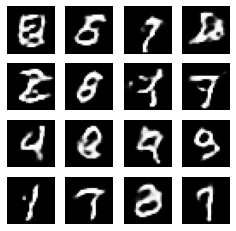

In [26]:
train(train_dataset, EPOCHS)